# **Simulation of free Particle using qubits**



Schodinger's equation:
$$
H\ket{\psi(t)} = i \hbar \frac{\partial}{\partial t} \ket{\psi(t)}
$$

where m=1/2, $\hbar$=1

$$
\ket{\psi(t)}=e^{-iHt}\ket{\psi(t)} 
$$

Seperating the kinetic and potential term:

$$
\ket{\psi(t)}=(e^{-ik\Delta t}e^{-iV\Delta t})^{\frac{t}{\Delta t}}\ket{\psi_{\text{init}}}
$$


In [43]:
import numpy as np
from numpy import pi
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister, QuantumRegister
import matplotlib.pyplot as plt
from qiskit.circuit.library import U1Gate,U3Gate,CU1Gate
from qiskit import Aer, execute
from qiskit.quantum_info import Statevector


In [44]:
def sim_sv(qc,text):
    """Get the statevecor of the output of the circuit qc"""
    sv_sim = Aer.get_backend('statevector_simulator')
    sv = execute (qc, sv_sim).result().get_statevector()
    return sv

In [45]:
#QFT
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    for i in range (n):
        circuit.h(i)
        m = 1
        for j in range (i+1,n):
            m = m +1; 
            cu1=CU1Gate(-2*pi/2**m)
            circuit.append(cu1,[i,j])
            
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit
def makeQFTgate(N):
    """returns a gate of centred QFT, swaps qubits"""
    temp = QuantumCircuit (N)
    swap_registers(temp, N)
    qft_rotations(temp,N)
    #temp.x(n-1);
    QFTC = temp.to_gate()
    QFTC.name = "QFT_" + str(N) 
    return QFTC

In [46]:
#Phase change, time evolution
def phase(n, phi):
    """returns the phase transformation gate for n qubits"""
    qc = QuantumCircuit(n+1);
    for i in range (n):
        u1=U1Gate(phi/(2**(i+n-3)))
        qc.append(u1,[n-1-i])

    for i in range (n):
        for j in range (i+1,n):
            qc.cx(n-1-j, n)
            qc.cx(n-1-i, n)
            
            u1=U1Gate(phi*(2**(2-i-j)))
            qc.append(u1,[n])
            
            qc.cx(n-1-i, n)
            qc.cx(n-1-j, n)
    phcirc = qc.to_gate()
    phcirc.name = 'phase'+str(phi)
    return phcirc

In [47]:
#Whole circuit
def evolve (n,phi,initial_state, stepsnumber):
    n1 = n+1
    snaps = []
    for i in range (stepsnumber):
        q = QuantumRegister(n1)
        qc = QuantumCircuit(q)
        qc.barrier();
        #initialization
        magnitude = np.linalg.norm(initial_state)
        initial_state =initial_state/magnitude
        qc.initialize(initial_state, list(range(n))) 
        qc.barrier();
        #QFT
        QFT = makeQFTgate(n)
        qc.append(QFT,range(n))
        qc.barrier();
        #phase
        ph = phase (n,(i+1)*phi)
        qc.append(ph,range(n+1))
        qc.barrier();
        #inverse QFT
        QFTi = QFT.inverse()
        QFTi.name = "QFTi_" + str(n)
        qc.append(QFTi,list(range(n)))
        qc.barrier()
       
        
        finalstate = sim_sv(qc,'\psi')
        statevector_array = np.array(finalstate)
        #print(finalstate)

        prob = np.square(abs(statevector_array))
        print("Probability: ", prob)
        print(finalstate)
        snaps.append(prob)
    return qc,snaps

In [48]:
#Plotting Result

def action ():
    qc,snaps = evolve(n,phi,initial_state, stepsnumber)
    print(initial_state)
    plt.plot(np.square(abs(initial_state)),'r')
    leg = ["initial"]
    for i in range (stepsnumber):
        plt.plot(snaps[i])
        leg. append ("step_"+str(i+1))
    x=plt.axis([0, 2**n-1, 0, 1.1*max(np.square(abs(initial_state)))])
    plt.legend(leg)
    return snaps



#**Gausian Initiation of qubits**

Initializing qubits with Gaussian wave packet
$$ \LARGE \ket{\psi_{\text{init}}}=e^{-\frac{\left(x - \mu \right)^2}{2\sigma^2}} e^{-ik(x - \mu) }
$$

Where:
$$
\mu=\frac{2^n}{2} - \frac{1}{2}
$$

Where $\sigma$ is basis vector or width at half maximum

/tmp/ipykernel_244914/905048685.py:4: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  sv = execute (qc, sv_sim).result().get_statevector()


Probability:  [0.00043949 0.00044833 0.00046542 0.00049179 0.00052922 0.00057924
 0.00064371 0.00072519 0.00082718 0.00095457 0.00111435 0.00131675
 0.00157693 0.00191726 0.00237014 0.00298111 0.00381174 0.0049412
 0.00646542 0.00849229 0.01113171 0.01447996 0.01859895 0.02349282
 0.0290856  0.03520543 0.04158055 0.04785128 0.05359958 0.05839375
 0.06184217 0.06364689 0.06364689 0.06184217 0.05839375 0.05359958
 0.04785128 0.04158055 0.03520543 0.0290856  0.02349282 0.01859895
 0.01447996 0.01113171 0.00849229 0.00646542 0.0049412  0.00381174
 0.00298111 0.00237014 0.00191726 0.00157693 0.00131675 0.00111435
 0.00095457 0.00082718 0.00072519 0.00064371 0.00057924 0.00052922
 0.00049179 0.00046542 0.00044833 0.00043949 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        

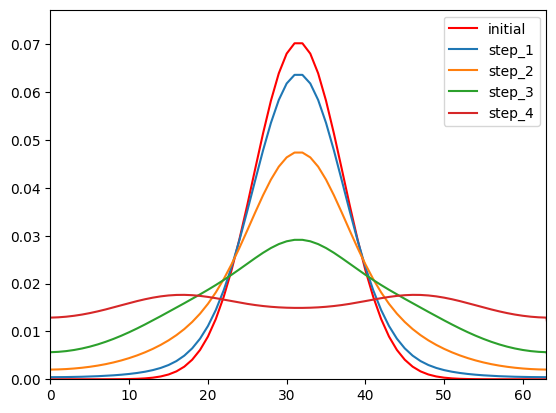

In [49]:
n = 6; ## number of qubits
phi = 0.25*2*pi;  
width= 2**n/8;
k=1; # k momentum; 
initial_state = (np.exp(-(np.linspace(0,2**n-1, 2**n) - (2**n/2) +0.5)**2/(2*width**2)))

magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude


stepsnumber = 4; 
snaps=action()


print("Initial State: ", initial_state)


In [50]:
from matplotlib.animation import FuncAnimation

In [51]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

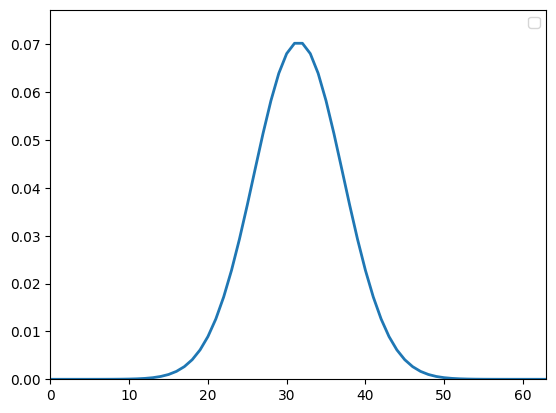

In [52]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

# Define the x and y data
x_data = np.arange(0, (2**n))  # x axis values
y_data = np.square(abs(initial_state))  # y axis values

ax.set_xlim((0, (2**n)-1))
ax.set_ylim((0, 1.1 * max(y_data)))  # Use max of y_data for scaling
plt.legend(["step_"])  # "step_" should be inside a list

line, = ax.plot(x_data, y_data, lw=2)  # Provide data to plot


In [53]:
# Plot the initial state directly before animation
x_initial = list(range(2**n))
y_initial = np.square(abs(initial_state))
line.set_data(x_initial, y_initial)
plt.show()


In [54]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    plt.legend([])
    return (line,)

In [55]:
# animation function. This is called sequentially
def animate(i):
    #x = np.linspace(0, 1, 2**(n+1))
    x = list(range(2**(n+1)))
    y = snaps[i]
    line.set_data(x, y)
    
    return (line,)

In [56]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=stepsnumber, interval=100)

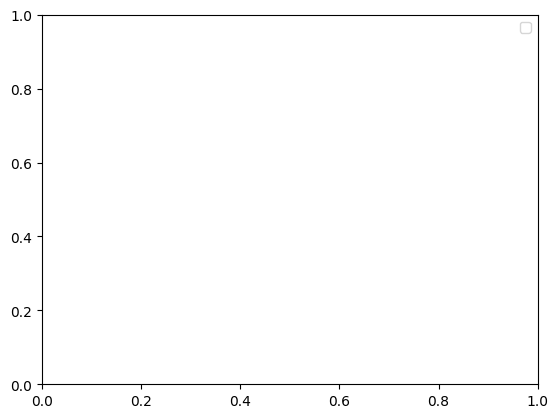

In [57]:
HTML(anim.to_html5_video())